**Flow:**
1. Load dataset
2. Preprocessing
3. Define NN
4. Training NN
5. Testing NN

In pt, you have to use data loaders, transformers and viz

In [1]:
import torch
import numpy as np
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler #for validation test
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
#Load and Viz data
#define a transform to convert imgs to tensors and normalize them doing both things together
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,),)
                              ])

#download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)

#validation set
indicies = list(range(len(trainset)))
np.random.shuffle(indicies)

#get 20% of train set
split = int(np.floor(0.2*len(trainset)))
train_sample = SubsetRandomSampler(indicies[:split])
valid_sample = SubsetRandomSampler(indicies[split:])




100%|██████████| 26.4M/26.4M [00:02<00:00, 11.2MB/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 173kB/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.23MB/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.30MB/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



**Data Loaders**

We use dataloaders becus the samples req by the model during training wont reach to the model if not use the loaders.

The number of loader is equal to number of sets we have.

In [4]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, sampler=train_sample)
validloader = torch.utils.data.DataLoader(trainset, batch_size=64, sampler=valid_sample)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [5]:
trainset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /root/.pytorch/F_MNIST_data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

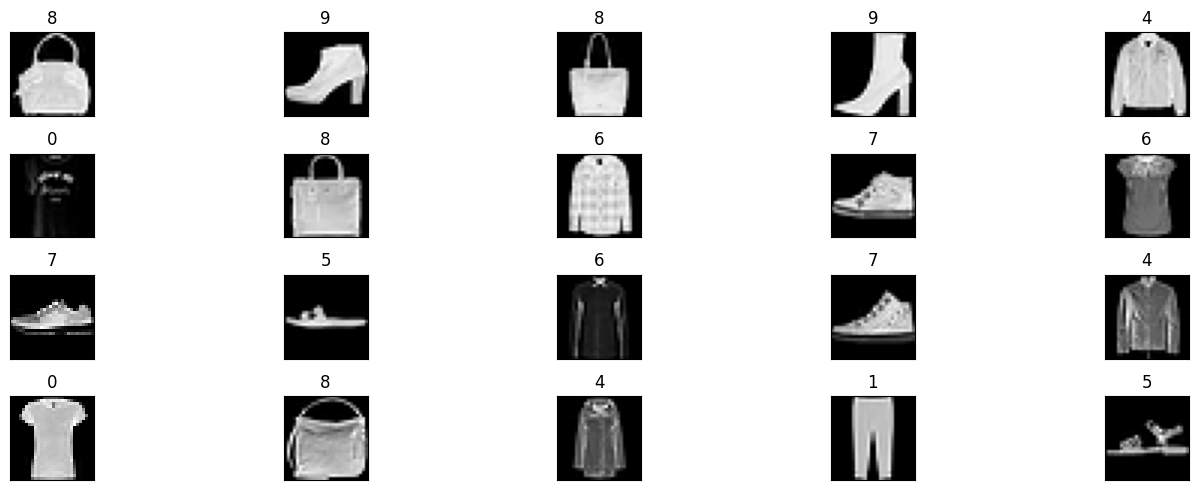

In [7]:
#viz the data
#create an itr for trainloader
dataiter = iter(trainloader)
print(dataiter)

#get next batch of data (imgs and labels)
images, labels = next(dataiter)

#create fig to display
fig = plt.figure(figsize=(15,5))

#loop thru first 20 imgs in batch
for idx in np.arange(20):
  #xticks and yticks is empty to print imgs wo any ticks around them
  ax = fig.add_subplot(4, int(20/4), idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap='gray')
  ax.set_title(f'{str(labels[idx].item())}')

fig.tight_layout()

#10 classes

In [8]:
#define NN, custom classifier class that inherits from nn.module
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()

    #define layers of nn
    #img is 28x28 and into tensor till 784 via ventor and flatten
    self.fc1 = nn.Linear(784, 120) #fully conntected layer 1 with 784 ip fts(ip size) and 120 op fts
    self.fc2 = nn.Linear(120,120) #layer 2
    self.fc3 = nn.Linear(120,10)  #fcn layer 3
    self.dropout = nn.Dropout(0.2) #dropout layer with a dropout probability of

  def forward(self,x):
    x=x.view(x.shape[0], -1) #flattening the input, reshaping ip tensor to have flat vector shape
    x = self.dropout(F.relu(self.fc1(x))) #relu activation func and dropout on 1st fcn layer
    x = self.dropout(F.relu(self.fc2(x))) #relu activation func and dropout on 2nd fcn layer
    x = F.log_softmax(self.fc3(x), dim=1) #log softmax activation func as multiclass classification

    return x


#####dropout is to prevent some neurons from dominating the output result, technique used in neural networks to prevent overfitting.
#####It works by randomly dropping out (setting to zero) a certain proportion of neurons during each training iteration.

In [9]:
from logging import log
#training and validating the model
model = Classifier()
criterion = nn.NLLLoss() #negative log likelihood loss
optimizer = optim.SGD(model.parameters(), lr=0.01) #gradient descent optimizer
valid_loss_min = np.Inf #init a var with high value to track the min val loss

epochs = 20
steps=0 #count training steps
model.train()
train_losses, valid_losses = [], []

for e in range(epochs):
  running_loss = 0
  valid_loss=0

  for images, labels in trainloader:
    optimizer.zero_grad() #clear gradients
    log_ps = model(images) #forward pass
    loss = criterion(log_ps, labels) #cal loss
    loss.backward() #backward gradient
    optimizer.step() #update weights
    running_loss += loss.item() * images.size(0)

  for images, labels in validloader:
    log_ps = model(images) #forward pass
    loss = criterion(log_ps, labels) #cal loss
    valid_loss += loss.item() * images.size(0)

  #cal avg losses for training and val
  running_loss = running_loss/len(trainloader.sampler)
  valid_loss = valid_loss/len(validloader.sampler)

  #append losses to their respective lists
  train_losses.append(running_loss)
  valid_losses.append(valid_loss)

  print(f'Epoch: {e+1}/{epochs} \t Training Loss: {running_loss:.3f} \t Validation Loss: {valid_loss:.3f}')

  #check if curr val loss is lower than minimum seen so far
  #saving model only if its less than b4 , cus in somecases loss start to increase and then there is no use to saving that model
  if valid_loss <= valid_loss_min:
    print(f'Validation loss decreased ({valid_loss_min:.3f} --> {valid_loss:.3f}).  Saving model ...')
    torch.save(model.state_dict(), 'model.pt')
    valid_loss_min = valid_loss

Epoch: 1/20 	 Training Loss: 1.996 	 Validation Loss: 1.532
Validation loss decreased (inf --> 1.532).  Saving model ...
Epoch: 2/20 	 Training Loss: 1.243 	 Validation Loss: 1.046
Validation loss decreased (1.532 --> 1.046).  Saving model ...
Epoch: 3/20 	 Training Loss: 0.951 	 Validation Loss: 0.876
Validation loss decreased (1.046 --> 0.876).  Saving model ...
Epoch: 4/20 	 Training Loss: 0.827 	 Validation Loss: 0.792
Validation loss decreased (0.876 --> 0.792).  Saving model ...
Epoch: 5/20 	 Training Loss: 0.762 	 Validation Loss: 0.730
Validation loss decreased (0.792 --> 0.730).  Saving model ...
Epoch: 6/20 	 Training Loss: 0.709 	 Validation Loss: 0.691
Validation loss decreased (0.730 --> 0.691).  Saving model ...
Epoch: 7/20 	 Training Loss: 0.671 	 Validation Loss: 0.662
Validation loss decreased (0.691 --> 0.662).  Saving model ...
Epoch: 8/20 	 Training Loss: 0.643 	 Validation Loss: 0.636
Validation loss decreased (0.662 --> 0.636).  Saving model ...
Epoch: 9/20 	 Trai

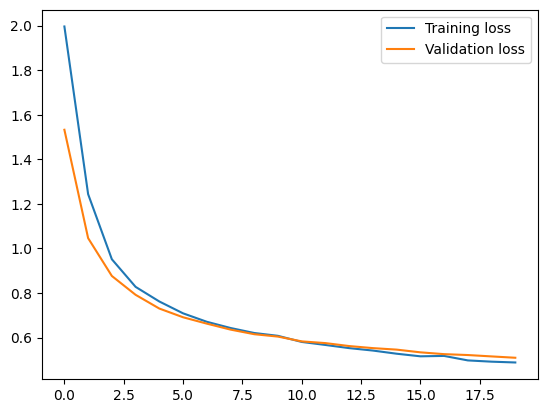

In [10]:
#viz is important here, as it help see how well our model is performing
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend()

In [11]:
#loading saved model
model.load_state_dict(torch.load('model.pt'))

<ipython-input-11-0daabd4e1e20>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pt'))


<All keys matched successfully>

In [12]:
#testing model
#track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
for images, labels in testloader:
  output = model(images) #forward pass
  loss = criterion(output, labels) #cal loss
  test_loss += loss.item()*images.size(0) #update test loss
  _, pred = torch.max(output, 1) #convert op probs to pred class
  correct= np.squeeze(pred.eq(labels.data.view_as(pred))) #compare pred with true labels
  #cal test accuracy
  for i in range(len(labels)):
    label = labels.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1

#cal and print test loss
test_loss = test_loss/len(testloader.dataset)
print(f'Test Loss: {test_loss:.3f}\n')

for i in range(10):
  if class_total[i] > 0:
    print(f'Test Accuracy of {i}: {int(100 * class_correct[i] / class_total[i])}% ({int(np.sum(class_correct[i]))}/{int(np.sum(class_total[i]))})')

  else:
    print(f'Test Accuracy of {i}:' % classes[i])

print(f'\nTest Accuracy (Overall): {int(100 * np.sum(class_correct) / np.sum(class_total))}% ({int(np.sum(class_correct))}/{int(np.sum(class_total))})')

#displaying accuracy class wise

Test Loss: 0.484

Test Accuracy of 0: 81% (819/1000)
Test Accuracy of 1: 94% (947/1000)
Test Accuracy of 2: 73% (736/1000)
Test Accuracy of 3: 84% (848/1000)
Test Accuracy of 4: 75% (751/1000)
Test Accuracy of 5: 88% (886/1000)
Test Accuracy of 6: 48% (481/1000)
Test Accuracy of 7: 89% (891/1000)
Test Accuracy of 8: 94% (943/1000)
Test Accuracy of 9: 93% (939/1000)

Test Accuracy (Overall): 82% (8241/10000)


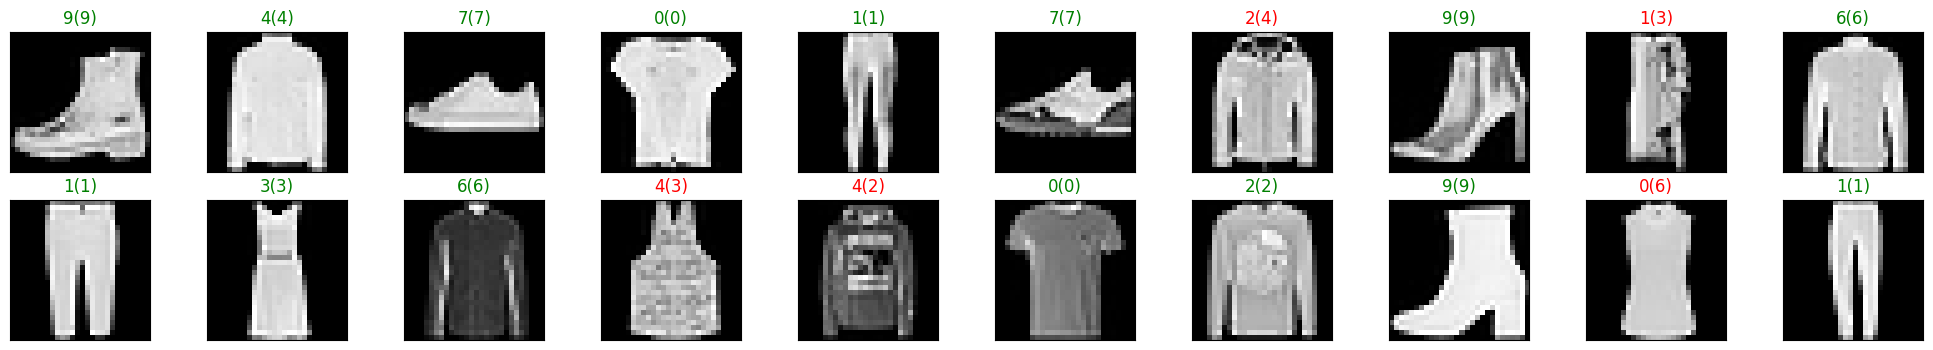

In [14]:
#obtain one batch of test imgs
dataiter = iter(testloader)
images, labels = next(dataiter)

#get sample outputs
output = model(images)

#convert op probs to pred class
_, preds = torch.max(output, 1)
#prep imgs for display
images = images.numpy()
#plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
  ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap='gray')
  ax.set_title("{}({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))


Improve result my increasing epochs and learning rate